In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#images_path ='C:/Users/getam/deep/caption/Flicker8k_Dataset/'
images_path ='C:/Users/user/Flicker8k_Dataset/'
captions_path ='data/am_cap.txt'
train_path = 'data/main.txt'
val_path = 'data/validate.txt'
test_path = 'data/test.txt'

captions = open(captions_path, 'r',encoding='utf-8').read().split("\n")
x_train = open(train_path, 'r',encoding='utf-8').read().split("\n")
x_val = open(val_path, 'r',encoding='utf-8').read().split("\n")
x_test = open(test_path, 'r',encoding='utf-8').read().split("\n")

In [3]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

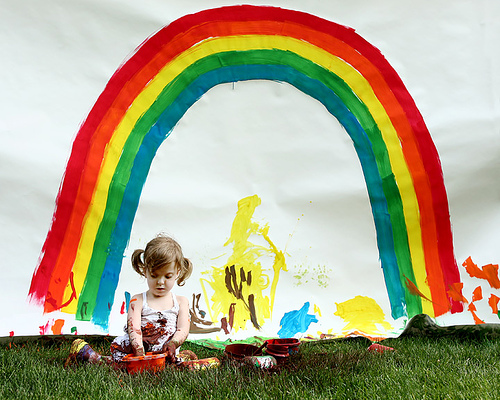

በቀለም የተሸፈነች ትንሽ ልጅ እጆ aን በገንዳ ውስጥ በተቀባ ቀስተ ደመና ፊት ለፊት ትቀመጣለች 
አንዲት ትንሽ ልጅ በትልቅ ቀለም ቀስተ ደመና ፊት ለፊት ተቀምጣለች 
በሳር ውስጥ ያለች አንዲት ትንሽ ልጅ ቀስተ ደመና ጋር በነጭ ሸራ ፊት ለፊት በጣት አሻራዎች ትጫወታለች 
ከቀስተ ደመና ሥዕል ፊት ለፊት የተቀመጠ አሳማ የያዘች አንዲት ልጅ አለች 
ከቤት ውጭ በሣር ውስጥ የአሳማ ሥጋ ሥዕልን የምትስል ልጃገረድ


In [4]:
# displaying an image and captions given to it
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [5]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [6]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [7]:
# Loading 50 layer Residual Network Model and getting the summary of the model
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [8]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [9]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000


In [10]:
train_data['2256133102_e2c8314ecb.jpg'].shape

(2048,)

In [11]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(7005, 2)


In [12]:
pd_dataset.head()

,image_id,captions
0,1079274291_9aaf896cc1.jpg,<start> አንድ ትንሽ ልጅ ምላሱን ለካሜራ ይወጣል ሌላ ልጅ ይመለከታል...
1,1079274291_9aaf896cc1.jpg,<start> ሁለት ወንዶች ልጆች ፊት ይሰራሉ ​​ <end>
2,1079274291_9aaf896cc1.jpg,<start> ሁለት ወጣት ወንዶች ካሜራውን እየተመለከቱ አንዱ ፈገግ ሲል ...
3,1079274291_9aaf896cc1.jpg,<start> ሁለት ወጣት ወንዶች አንደኛው አንደበትን ሲያወጣ ካሜራውን ቀ...
4,1079274291_9aaf896cc1.jpg,<start> ሁለት ወጣት ወንዶች ሞኝ ፊቶችን ያደርጋሉ <end>


In [13]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

7005


In [14]:
# First 5 captions stored in sentences
sentences[:5]

['<start> አንድ ትንሽ ልጅ ምላሱን ለካሜራ ይወጣል ሌላ ልጅ ይመለከታል <end>',
 '<start> ሁለት ወንዶች ልጆች ፊት ይሰራሉ \u200b\u200b <end>',
 '<start> ሁለት ወጣት ወንዶች ካሜራውን እየተመለከቱ አንዱ ፈገግ ሲል ሌላኛው ምላሱን አወጣ <end>',
 '<start> ሁለት ወጣት ወንዶች አንደኛው አንደበትን ሲያወጣ ካሜራውን ቀና ብለው ይመለከታሉ <end>',
 '<start> ሁለት ወጣት ወንዶች ሞኝ ፊቶችን ያደርጋሉ <end>']

In [15]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [16]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

7038


In [17]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [18]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 7039

In [19]:
indices_2_word[0] = 'UNK'
indices_2_word[7039] = 'raining'

In [20]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[6666])

5247
ጎዳናዎች
4245
ሥጋ


In [21]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

7040


In [22]:
#maximum length of sentence
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

27


In [23]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(7005,)
(7005,)


C:\Users\user\anaconda3\envs\deep1\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [24]:
print(padded_sequences[0])

[[5247    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5247 4828    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5247 4828 4150    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5247 4828 4150  661    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5247 4828 4150  661 1052    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5247 4828 4150  661 1052 6924    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5247 4828 4150  661 1052 6924 1411    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5247 4828 4150  66

In [25]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
ትንሽ
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
ትንሽ
ልጅ
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
ትንሽ
ልጅ
ምላሱን
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
ትንሽ
ልጅ
ምላሱን
ለካሜራ
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
ትንሽ
ልጅ
ምላሱን
ለካሜራ
ይወጣል
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
ትንሽ
ልጅ
ምላሱን
ለካሜራ
ይወጣል
ሌላ
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
አንድ
ትንሽ
ልጅ
ምላሱን
ለካሜራ
ይወጣል
ሌላ
ልጅ
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
U

In [26]:
num_of_images = 1800

In [27]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [28]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(17908, 27)
(17908, 7040)


In [29]:
with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [30]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0].encode() in encoded_images.keys():
#         print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0].encode()]))

imgs = np.asarray(imgs)
print(imgs.shape)

(2600, 2048)


In [31]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(17908, 2048)


In [32]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

17908


In [33]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(17908, 27)
(17908, 7040)


In [34]:
images = np.load("images.npy")

print(images.shape)

(17908, 2048)


In [35]:
imag = np.load("image_names.npy")
        
print(imag.shape)

(17908,)


In [45]:
embedding_size = 128
max_len = 27

In [46]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 27, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [47]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 27, 128)           901120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 27, 256)           394240    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 27, 128)           32896     
Total params: 1,328,256
Trainable params: 1,328,256
Non-trainable params: 0
_________________________________________________________________


In [48]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_3_input (InputLayer)  (None, 27)           0                                            
__________________________________________________________________________________________________
dense_6_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 27, 128)      901120      embedding_3_input[0][0]          
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          262272      dense_6_input[0][0]              
____________________________________________________________________________________________

In [49]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200,verbose = 1)

C:\Users\user\anaconda3\envs\deep1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
17908/17908 [==============================] - 142s 8ms/step - loss: 6.5694 - accuracy: 0.0977
Epoch 2/200
17908/17908 [==============================] - 120s 7ms/step - loss: 6.1491 - accuracy: 0.1005
Epoch 3/200
17908/17908 [==============================] - 119s 7ms/step - loss: 6.0479 - accuracy: 0.1146
Epoch 4/200
17908/17908 [==============================] - 120s 7ms/step - loss: 5.9123 - accuracy: 0.1275
Epoch 5/200
17908/17908 [==============================] - 120s 7ms/step - loss: 5.8042 - accuracy: 0.1309
Epoch 6/200
17908/17908 [==============================] - 122s 7ms/step - loss: 5.7307 - accuracy: 0.1384
Epoch 7/200
17908/17908 [==============================] - 121s 7ms/step - loss: 5.6690 - accuracy: 0.1380
Epoch 8/200
17908/17908 [==============================] - 123s 7ms/step - loss: 5.6086 - accuracy: 0.1396
Epoch 9/200
17908/17908 [==============================] - 123s 7ms/step - loss: 5.5638 - accuracy: 0.1431
Epoch 10/200
17908/17908 [===========

17908/17908 [==============================] - 85s 5ms/step - loss: 0.3222 - accuracy: 0.8801
Epoch 152/200
17908/17908 [==============================] - 85s 5ms/step - loss: 0.3333 - accuracy: 0.8753
Epoch 153/200
17908/17908 [==============================] - 85s 5ms/step - loss: 0.3254 - accuracy: 0.8794
Epoch 154/200
17908/17908 [==============================] - 85s 5ms/step - loss: 0.3177 - accuracy: 0.8799
Epoch 155/200
17908/17908 [==============================] - 86s 5ms/step - loss: 0.3108 - accuracy: 0.8826
Epoch 156/200
17908/17908 [==============================] - 86s 5ms/step - loss: 0.3173 - accuracy: 0.8824
Epoch 157/200
17908/17908 [==============================] - 85s 5ms/step - loss: 0.3295 - accuracy: 0.8765
Epoch 158/200
17908/17908 [==============================] - 85s 5ms/step - loss: 0.3009 - accuracy: 0.8846
Epoch 159/200
17908/17908 [==============================] - 86s 5ms/step - loss: 0.3302 - accuracy: 0.8778
Epoch 160/200
17908/17908 [===============

In [50]:
model.save_weights("model_weights.h5")

In [61]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [62]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [63]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [64]:
img = 'C:/Users/user/Desktop/Arabic-Image-Captioning-master/Flicker8k_Dataset/179829865_095b040377.jpg'

test_img = get_encoding(resnet, img)

In [65]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

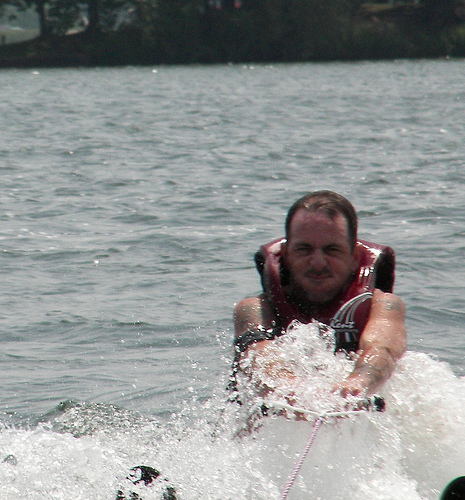

አንዲት ወጣት የለበሰ ወፍ ከነጭ ማቆሚያ ግድግዳ ላይ ቆሟል


In [66]:
z = Image(filename=img)
display(z)

print(Argmax_Search)

In [57]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
ref =[['አንድ','ልጅ','በአልጋ','ላይ','እየዘለለ','ነው']]
can =['አንድ','ልጅ','ውስጥ','ላይ']
score =sentence_bleu(ref, can)
print(score)

6.397495320955232e-155


C:\Users\user\anaconda3\envs\deep1\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\anaconda3\envs\deep1\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [49]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'this is a dog'.split(),
    'it is dog'.split(),
    'dog it is'.split(),
    'a dog, it is'.split() 
]
candidate = 'it is dog'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate )))

candidate = 'it is a dog'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))

BLEU score -> 1.2213386697554703e-77
BLEU score -> 1.0270193092081295e-77


C:\Users\user\anaconda3\envs\deep1\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
